<a href="https://colab.research.google.com/github/spla23/Predicting-Job-Scores/blob/main/Predict_Rating_from_Review_Text_LSTM_with_OHE_and_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicting Glassdoor Ratings from Reviews

**Frameworks**

Train a machine learning model to predict the star rating assigned to a job by an employee, based on the content of the review text.

We will use NLP frameworks to extract and rank the impact weights of the review text as feature input.
We will use hot-encoded categories as our training set to determine the weights of features and our desired prediction outcome.

**Problem, Hypothesis, Use Cases**

Our goal is to determine which words and phrases are highly correlated with a '1 star job' rating and a '5 star' job rating in the field of data science.

We will use the Glassdoor star rating system as a proxy for 'job quality', and assume a job ranked '5 stars' by an employee is a 'good job' that someone would enjoy and a '1 star job' is a bad job.

We assume there are specific words and phrases that will be repeated in the review text that are the 'features' of a 'good job' (a '5 star job') and a 'bad job'.

As an example, the phrase "learned a lot during my time there" may be associated with a '4 star' or '5 star' job rating. A '1 star' job might see a lot of employees saying "bad manager" in the "cons" section.

If given some other text in context with the job, could we predict the quality of a job experience based on the words and phrases used?

Could theese be used as 'red flags' or 'green light' signals to job seekers in the domain of data science?

**Labels**

The Star Rating Assigned to a Review: 'One Star' to 'Five Stars'

**Features**

words in the review text
sentences in the review text

**Dataset**

Dataset comes from Kaggle https://www.kaggle.com/andresionek/data-jobs-listings-glassdoor
Initial set is 1.48 GB with more than 160k rows and 265 columns in 15 tables

Data consists of Scraped Glassdoor company listings, job listings and review text for data science related search terms, for every country:
* data-scientist
* software-engineer
* data-analyst
* research-scientist
* business-analyst
* product-manager
* project-manager
* data-engineer
* statistician
* dba
* database-engineer
* machine-learning-engineer


*For predicting the rating of a glassdoor review, I will be using the review text and ratings data only. For prototypes, I have sliced the data thinly and will expand as time warrants. This will reduce the scope of the data significantly to reduce load and runtime.*

**Model**

We will be using a classification model to predicts the discrete ratings values.
The ratings are discrete per review, so the rating prediction will be discrete.
There are 5 possible inputs: 'One Star', 'Two Stars', 'Three Stars', 'Four Stars', 'Five Stars', 
Accordingly, there will be 5 possible prediction values.
This model will detect words and phrases in text that are highly correlated with five rating labels and predict the rating from unlabeled text.

**Method**

Explore and Clean Data

Extract cleaned text and ratings as input

Encode word and sentence vectors/tokens

Train Machine Learning Models to assign weights to inputs


The model will be trained to learn the relationships between 'review text' and 'star rating'.


The trained model will be apply what it's learned to unrated review text and predict the star rating for each.


We will then evaluate the accuracy of the prediction and tune the results by experimenting with more NLP, feature extraction frameworks and machine learning models.

## Data Cleaning, Shaping and Exploration

### Load data

In [1]:
#import libraries
import pandas as pd

import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

import matplotlib.pyplot as plt


from pathlib import Path
import re
#import hvplot.pandas
#import holoviews as _hv
#from holoviews import Store
%matplotlib inline
import seaborn as sns



import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import reuters, stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler


import tensorflow as tf
from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.utils.vis_utils import plot_model

# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image


# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

from numpy.random import seed
#seed(1)
from tensorflow import random
#random.set_seed(2)

# Code to download corpora for TF-IDF
import nltk
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#Import Libraries




[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the review data
glassdoor_reviews_df=pd.read_csv('glassdoor_reviews.csv')
glassdoor_reviews_df

# Preview column names and info about data
glassdoor_reviews_df.info(), glassdoor_reviews_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422180 entries, 0 to 422179
Data columns (total 28 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   id                                             422180 non-null  int64  
 1   index                                          343221 non-null  float64
 2   reviews.val.cons                               343214 non-null  object 
 3   reviews.val.date                               343221 non-null  object 
 4   reviews.val.featured                           343221 non-null  object 
 5   reviews.val.helpfulCount                       343221 non-null  float64
 6   reviews.val.id                                 343221 non-null  float64
 7   reviews.val.pros                               343221 non-null  object 
 8   reviews.val.publishedOn                        343221 non-null  object 
 9   reviews.val.publisher                

(None, (422180, 28))

In [4]:
#backup and reviewer headers
#backup1 = glassdoor_reviews_df.copy()#for testing purposes
glassdoor_reviews_df.head()

,id,index,reviews.val.cons,reviews.val.date,reviews.val.featured,reviews.val.helpfulCount,reviews.val.id,reviews.val.pros,reviews.val.publishedOn,reviews.val.publisher,reviews.val.reviewRatings.careerOpportunities,reviews.val.reviewRatings.compBenefits,reviews.val.reviewRatings.cultureValues,reviews.val.reviewRatings.overall,reviews.val.reviewRatings.seniorManagement,reviews.val.reviewRatings.worklifeBalance,reviews.val.reviewerDuration,reviews.val.reviewerInformation,reviews.val.reviewerJobTitle,reviews.val.reviewerLocation,reviews.val.reviewerStatus,reviews.val.summaryPoints.ceoApproval,reviews.val.summaryPoints.outlook,reviews.val.summaryPoints.recommend,reviews.val.title,reviews.val.adviceToManagement,reviews.val.companyResponse,reviews.val.reviewResponses
0,44001,0.0,Still not big enough in market place,"Oct 20, 2010",False,0.0,689142.0,"Great brand , Good leadership , Clear business...","Oct 20, 2010",Director,5.0,3.5,0.0,5.0,5.0,5.0,NaN,Former Employee: I worked at American Express,Director,Tokyo (Japan),Former Employee,1.0,0.0,1.0,American Express Japan - Excellent place to work,None,NaN,NaN
1,44002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44004,0.0,Nothing important on my point of view.,4 weeks ago,False,0.0,29659857.0,"Learn new technologies, helpful people, good m...",4 weeks ago,Software Engineer(Internship),5.0,5.0,5.0,5.0,5.0,5.0,for less than a year,Former Employee: I worked at Eventum IT Soluti...,Software Engineer(Internship),Alexandria (Egypt),Former Employee,1.0,1.0,1.0,one of the best places to be intern in,NaN,NaN,NaN
4,44004,1.0,Alot of friends working together which isn't v...,"May 29, 2019",False,0.0,26381884.0,Very good opportunities to learn technologies,"May 29, 2019",Network Engineer,5.0,5.0,5.0,5.0,5.0,5.0,for more than 5 years,Current Employee: I have been working at Event...,Network Engineer,Alexandria (Egypt),Current Employee,1.0,1.0,1.0,Very Good Company,NaN,NaN,NaN


#### Clean data

In [5]:
#delete Nans (rows without a review ID)
glassdoor_reviews_df.dropna(subset = ["reviews.val.id"], inplace=True)

In [6]:
#filter for english speaking locations - eliminate non-english reviews
glassdoor_reviews_df = glassdoor_reviews_df.set_index("reviews.val.reviewerLocation")#set index as location to filter for list values
glassdoor_reviews_df.columns

Index(['id', 'index', 'reviews.val.cons', 'reviews.val.date',
       'reviews.val.featured', 'reviews.val.helpfulCount', 'reviews.val.id',
       'reviews.val.pros', 'reviews.val.publishedOn', 'reviews.val.publisher',
       'reviews.val.reviewRatings.careerOpportunities',
       'reviews.val.reviewRatings.compBenefits',
       'reviews.val.reviewRatings.cultureValues',
       'reviews.val.reviewRatings.overall',
       'reviews.val.reviewRatings.seniorManagement',
       'reviews.val.reviewRatings.worklifeBalance',
       'reviews.val.reviewerDuration', 'reviews.val.reviewerInformation',
       'reviews.val.reviewerJobTitle', 'reviews.val.reviewerStatus',
       'reviews.val.summaryPoints.ceoApproval',
       'reviews.val.summaryPoints.outlook',
       'reviews.val.summaryPoints.recommend', 'reviews.val.title',
       'reviews.val.adviceToManagement', 'reviews.val.companyResponse',
       'reviews.val.reviewResponses'],
      dtype='object')

In [7]:
#filter for english speaking locations - eliminate non-english reviews (start with one to keep)
locations_to_keep = ['Dublin, Co. Dublin (Ireland)',
                     'Toronto, ON (Canada)',
                     'Dorking, England',
                     'Calgary, AB (Canada)',
                     'Southampton, England',
                     'Billingham, England',
                     'Auckland, Auckland (New Zealand)',
                     'Perth, Western Australia (Australia)',
                     'Seattle, WA (US)',
                     'Austin, TX (US)',
                     'Montreal, QC (Canada)',
                     'San Mateo, CA (US)',
                     'Sandton (South Africa)',
                     'Aurora, CO (US)',
                     'London, England',
                     'Madison, WI (US)',
                     'Sydney (Australia)',
                     'Melbourne (Australia)',
                     'Carrick-on-Shannon (Ireland)',
                     'Birmingham, England',
                     'Belfast, Northern Ireland',
                     'Vancouver, BC (Canada)',
                     'New York, NY (US)',
                     'Irvine, CA (US)',
                     'Tempe, AZ (US)',
                     'Stellenbosch (South Africa)',
                     'Cork (Ireland)',
                     'Ottawa, ON (Canada)',
                     'Agawam, MA (US)',
                     'Brackenfell (South Africa)',
                     'Saint-Laurent, QC (Canada)',
                     'Stockport, England',
                     'Wexford (Ireland)',
                     'Richmond, VA (US)',
                     'Johannesburg (South Africa)',
                     'Orange, CA (US)',
                     'Bellevue, WA (US)',
                     'Chiswick, England',
                     'Mississauga, ON (Canada)',
                     'Cape Town (South Africa)',
                     'Winnipeg, MB (Canada)',
                     'Ipswich, MA (US)',
                     'Newbury, England',
                     'Stevens Point, WI (US)',
                     'Edinburgh, Scotland',
                     'Alpharetta, GA (US)',
                     'Arlington, VA (US)',
                     'Edmonton, AB (Canada)',
                     'Newcastle upon Tyne, England',
                     'Reston, VA (US)',
                     'Copenhagen (Denmark)',
                     'Santa Barbara, CA (US)',
                     'Leeds, England',
                     'Laval, QC (Canada)',
                     'Charlotte, NC (US)',
                     'Miami, FL (US)',
                     'Somerset West (South Africa)',
                     'Basking Ridge, NJ (US)',
                     'Winnersh, England',
                     'Natick, MA (US)',
                     'Los Angeles, CA (US)',
                     'Naples, FL (US)',
                     'Redding, CA (US)',
                     'Albuquerque, NM (US)',
                     'Galway (Ireland)',
                     'Pretoria, Gauteng (South Africa)',
                     'Wellington, Wellington (New Zealand)',
                     'Lincoln (New Zealand)',
                     'Palmdale, CA (US)',
                     'Glasgow, Scotland',
                     'Limerick, Co. Limerick (Ireland)',
                     'Chagrin Falls, OH (US)',
                     'Warrington, North West England, England',
                     'San Francisco, CA (US)',
                     'Sheffield, England',
                     'Cameron, LA (US)',
                     'Spring City, TN (US)',
                     'Richmond, London, England',
                     'Leicester, England',
                     'Des Moines, IA (US)',
                     'Los Alamos, NM (US)',
                     'Burlington, MA (US)',
                     'Sacramento, CA (US)',
                     'Sunnyvale, CA (US)',
                     'Durham, NC (US)',
                     'Jacksonville, FL (US)',
                     'Beaverton, OR (US)',
                     'Purchase, NY (US)',
                     'Pittsburgh, PA (US)',
                     'San Jose, CA (US)',
                     'Cambridge, MA (US)',
                     'Portsmouth, NH (US)',
                     'Stevenage, England',
                     'Nottingham, England',
                     'Hazelwood, England',
                     'Redlands, CA (US)',
                     'Guelph, ON (Canada)',
                     'North Sydney (Australia)',
                     'Roseville, CA (US)',
                     'Alexandria, VA (US)',
                     'Thames Ditton, England',
                     'San Carlos, CA (US)',
                     'High Wycombe, England',
                     'Heathrow, England',
                     'Santa Clara, CA (US)',
                     'Cambridge, England',
                     'Oakville, ON (Canada)',
                     'Brisbane (Australia)',
                     'Santa Monica, CA (US)',
                     'Waterloo, ON (Canada)',
                     'Lower Hutt (New Zealand)',
                     'Huntingdon, England',
                     'Markham, ON (Canada)',
                     'San Antonio, TX (US)',
                     'Lexington, MA (US)',
                     'Wakefield, MA (US)',
                     'Moorpark, CA (US)',
                     'Salem, OR (US)',
                     'Melville, NY (US)',
                     'Pasadena, CA (US)',
                     'Reading, PA (US)',
                     'Brampton, ON (Canada)',
                     'Tysons, VA (US)',
                     'Boston, MA (US)',
                     'Provo, UT (US)',
                     'Lebanon, NH (US)',
                     'Stafford, England',
                     'North Ryde (Australia)',
                     'Blackpool, England',
                     'Lytham St Annes, England',
                     'Lytham, England',
                     'Charleston, SC (US)',
                     'Portland, OR (US)',
                     'Killarney (Ireland)',
                     'Columbus, GA (US)',
                     'Salt Lake City, UT (US)',
                     'Orem, UT (US)',
                     'Simi Valley, CA (US)',
                     'Crawley, West Sussex, South East England, England',
                     'Wilton, CT (US)',
                     'Washington, DC (US)',
                     'Southfield, MI (US)',
                     'Adelaide (Australia)',
                     'Woodcliff Lake, NJ (US)',
                     'North York, ON (Canada)',
                     'Welwyn Garden City, England',
                     'Dallas, TX (US)',
                     'Orlando, FL (US)',
                     'Chicago, IL (US)',
                     'Surry Hills (Australia)',
                     'Pinelands, Western Cape (South Africa)',
                     'Cardiff, Wales',
                     'Malmesbury, England',
                     'Christchurch, Canterbury (New Zealand)',
                     'Bristol, England',
                     'Dundee, Scotland',
                     'Chantilly, VA (US)',
                     'Canberra (Australia)',
                     'Rohnert Park, CA (US)',
                     'Bloomington, MN (US)',
                     'Livermore, CA (US)',
                     'Hauppauge, NY (US)',
                     'Atlanta, GA (US)',
                     'Kelowna, BC (Canada)',
                     'Birmingham, AL (US)',
                     'Alcobendas (Spain)',
                     'Winslow, ME (US)',
                     'Columbus, OH (US)',
                     'Didcot, England',
                     'South Plainfield, NJ (US)',
                     'Manchester, England',
                     'Huntsville, AL (US)',
                     'Dartmouth, NS (Canada)',
                     'Anchorage, AK (US)',
                     'Bracknell, England',
                     'Palo Alto, CA (US)',
                     'Milpitas, CA (US)',
                     'Raleigh, NC (US)',
                     'Montevideo (Uruguay)',
                     'Nizhniy Novgorod (Russia)',
                     'Ta’if (Saudi Arabia)',
                     'Kitchener, ON (Canada)',
                     'Parkville (Australia)',
                     'Täby, Stockholm (Sweden)',
                     'Burnaby, BC (Canada)',
                     'Turlock, CA (US)',
                     'Senneville, QC (Canada)',
                     'Maadi Cornish (Egypt)',
                     'Dorchester, MA (US)',
                     'Andros Town (Bahamas)',
                     'Liverpool, England',
                     'Exeter, England',
                     'Plzeň (Czech Republic)',
                     'Saskatoon, SK (Canada)',
                     'Roxby Downs (Australia)',
                     'Niles, IL (US)',
                     'Warner Robins, GA (US)',
                     'Leixlip (Ireland)',
                     'Liberty Lake, WA (US)',
                     'Champaign, IL (US)',
                     'Guilford, CT (US)',
                     'Lenexa, KS (US)',
                     'San Diego, CA (US)',
                     'Edendale (New Zealand)',
                     'Danbury, CT (US)',
                     'Dokki (Egypt)',
                     'Victoria, BC (Canada)',
                     'Bloomington, IL (US)',
                     'Foster City, CA (US)',
                     'Paramaribo (Suriname)',
                     'Richmond, BC (Canada)',
                     'Colorado Springs, CO (US)',
                     'Oxford, England',
                     'Baltimore, MD (US)',
                     'Minneapolis, MN (US)',
                     'Carlisle, England',
                     'Altrincham, England',
                     'Gainesville, FL (US)',
                     'Fredericton, NB (Canada)',
                     'Redwood City, CA (US)',
                     'Dayton, OH (US)',
                     'Lanett, AL (US)',
                     'Cheltenham, England',
                     'Bloemfontein (South Africa)',
                     'Naas (Ireland)',
                     'Watertown, MA (US)',
                     'Duluth, GA (US)',
                     'Burlington, ON (Canada)',
                     'Kilkenny (Ireland)',
                     'Columbia, MD (US)',
                     'Palm Springs, FL (US)',
                     'Halifax, NS (Canada)',
                     'Hamilton, Waikato (New Zealand)',
                     'Phoenix, AZ (US)',
                     'Hatfield, East of England, England',
                     'Anjou, QC (Canada)',
                     'Lacey, WA (US)',
                     'Kirkland, QC (Canada)',
                     'Indianapolis, IN (US)',
                     'Temple Terrace, FL (US)',
                     'Denver, CO (US)',
                     'Annapolis Junction, MD (US)',
                     'Ebeye (Marshall Islands)',
                     'Wilmington, DE (US)',
                     'Horsham, England',
                     'Pine Grove, PA (US)',
                     'Kingston (Jamaica)',
                     'McLean, VA (US)',
                     'Whangarei, Northland (New Zealand)',
                     'Geelong (Australia)',
                     'Coventry, England',
                     'Townsville (Australia)',
                     'Bathgate, Scotland',
                     'Houston, TX (US)',
                     'Durban (South Africa)',
                     'Chorley, England',
                     'Reading, England',
                     'Okemos, MI (US)',
                     'Round Rock, TX (US)',
                     'Stoughton, MA (US)',
                     'Deerfield, IL (US)',
                     'London, ON (Canada)',
                     'Springfield, VA (US)',
                     'Swindon, Wiltshire, South West England, England',
                     'Croydon, Victoria (Australia)',
                     'Whippany, NJ (US)',
                     'Rosemead, CA (US)',
                     'Las Vegas, NV (US)',
                     'Saint Paul, MN (US)',
                     'Capitol Heights, MD (US)',
                     'Bellingham, WA (US)',
                     'Roxburgh (New Zealand)',
                     'Gibraltar (Gibraltar)',
                     'Conshohocken, PA (US)',
                     'Codsall, England',
                     'Oak Brook, IL (US)',
                     'Northampton, England',
                     'Johns Creek, GA (US)',
                     'Boucherville, QC (Canada)',
                     'Hillsboro, OR (US)',
                     'Dundalk (Ireland)',
                     'Al Aḩmadī (Kuwait)',
                     'Al ‘Udaylīyah (Kuwait)',
                     'New Orleans, LA (US)',
                     'Lowell, AR (US)',
                     'Warton, Lancashire, Lancashire, North West England, England',
                     'Miami Lakes, FL (US)',
                     'Sherwood, AR (US)',
                     'Princeton, NJ (US)',
                     'Newcastle (South Africa)',
                     'Valencia, CA (US)',
                     'San Luis Obispo, CA (US)',
                     'Bedford, NS (Canada)',
                     'Chatswood (Australia)',
                     'Dún Laoghaire (Ireland)',
                     'Cheadle, West Midlands, England',
                     'Mountain View, CA (US)',
                     'Saint Louis, MO (US)',
                     'Kingston, ON (Canada)',
                    ]

In [8]:
#select friom index location titles to keep in scope
glassdoor_reviews_df = glassdoor_reviews_df.loc[locations_to_keep]
glassdoor_reviews_df.reset_index(inplace=True)

In [9]:
#Create a new column with a concatenated review (combo of all review text fields)
full_review_columns = ['full_review', 'Rating_overall']
full_df = pd.DataFrame(columns=full_review_columns)

In [10]:
#Create new dataframe consisting of all review text and overall ratings
full_review_column = glassdoor_reviews_df['reviews.val.title'].astype(str) + ' ' + glassdoor_reviews_df['reviews.val.pros'].astype(str) + ' ' + glassdoor_reviews_df['reviews.val.cons'].astype(str) + ' ' + glassdoor_reviews_df['reviews.val.adviceToManagement'].astype(str)
full_df.full_review = full_review_column
full_df.Rating_overall = glassdoor_reviews_df['reviews.val.reviewRatings.overall']
full_df

,full_review,Rating_overall
0,"Not for faint-hearted Fast paced, technology, ...",5.0
1,Managers sold their soul to Verizon Good Team ...,1.0
2,Toxic environment and terrible management Oppo...,2.0
3,Fair The job is what was told. Very fair. Stil...,3.0
4,Good Company I have been working for the compa...,4.0
...,...,...
64881,Organized and supportive Great community spiri...,5.0
64882,Ph.D salary Flexibility of time; Convenience o...,3.0
64883,Queen's University Work Study Program Hours ar...,4.0
64884,"M.ENG program good facility in the campus, goo...",4.0


In [11]:
# create labels
# review_columns = ['OneStar', 'TwoStars', 'ThreeStars', 'FourStars', 'FiveStars']
# review_labels = pd.DataFrame(columns=review_columns)
# fill frame 
# review_labels.OneStar = pros_dummies['Ratings_overall_1.0']
# review_labels.TwoStars = pros_dummies['Ratings_overall_2.0']
# review_labels.ThreeStars = pros_dummies['Ratings_overall_3.0']
# review_labels.FourStars = pros_dummies['Ratings_overall_4.0']
# review_labels.FiveStars = pros_dummies['Ratings_overall_5.0']
# review_labels


#### Shape data
starting with simple subset of data - to be expanded as time allows

In [12]:
#define variables for different dataframes (isolating text fields)

#create simple dataframes with pro review text and overall rating
pro_df_columns = ['pros', 'Rating_overall']
pro_df = pd.DataFrame(columns=pro_df_columns)
#fill frame 
pro_df.pros = glassdoor_reviews_df['reviews.val.pros']
pro_df.Rating_overall = glassdoor_reviews_df['reviews.val.reviewRatings.overall']
pro_df.dropna(inplace=True)
pro_df.shape

(64886, 2)

In [13]:
pro_df.head()

,pros,Rating_overall
0,"Fast paced, technology, innovation, supportive...",5.0
1,Good Team of people in Dublin and UK,1.0
2,"Opportunity to learn by doing, under a lot of ...",2.0
3,The job is what was told. Very fair.,3.0
4,I have been working for the company for about ...,4.0


In [14]:
#create simple dataframes with con review text and overall rating
con_df_columns = ['cons', 'Rating_overall']
con_df = pd.DataFrame(columns=con_df_columns)
#fill frame 
con_df.cons = glassdoor_reviews_df['reviews.val.cons']
con_df.Rating_overall = glassdoor_reviews_df['reviews.val.reviewRatings.overall']
con_df.dropna(inplace=True)
con_df.shape

(64886, 2)

In [15]:
#create simple dataframes with advice to management text and overall rating
advice_df_columns = ['advice', 'Rating_overall']
advice_df = pd.DataFrame(columns=advice_df_columns)
#fill frame 
advice_df.advice = glassdoor_reviews_df['reviews.val.adviceToManagement']
advice_df.Rating_overall = glassdoor_reviews_df['reviews.val.reviewRatings.overall']
advice_df.dropna(inplace=True)
advice_df.shape

(35023, 2)

In [16]:
#create simple dataframes with reveiw title text and overall rating
title_df_columns = ['title', 'Rating_overall']
title_df = pd.DataFrame(columns=title_df_columns)
#fill frame 
title_df.title = glassdoor_reviews_df['reviews.val.title']
title_df.Rating_overall = glassdoor_reviews_df['reviews.val.reviewRatings.overall']
title_df.dropna(inplace=True)
title_df.shape

(64816, 2)

In [17]:
full_df

,full_review,Rating_overall
0,"Not for faint-hearted Fast paced, technology, ...",5.0
1,Managers sold their soul to Verizon Good Team ...,1.0
2,Toxic environment and terrible management Oppo...,2.0
3,Fair The job is what was told. Very fair. Stil...,3.0
4,Good Company I have been working for the compa...,4.0
...,...,...
64881,Organized and supportive Great community spiri...,5.0
64882,Ph.D salary Flexibility of time; Convenience o...,3.0
64883,Queen's University Work Study Program Hours ar...,4.0
64884,"M.ENG program good facility in the campus, goo...",4.0


## EDA

In [18]:
full_df.shape

(64886, 2)

In [19]:
full_df.value_counts(full_df['Rating_overall'])

Rating_overall
5.0    29974
4.0    15569
3.0     8201
1.0     6110
2.0     5032
dtype: int64

Text(0.5, 0, 'stars')

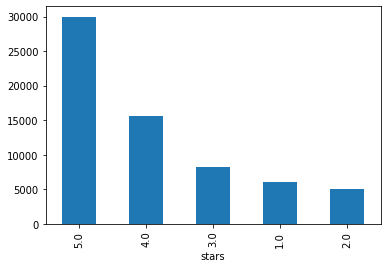

In [20]:
full_df.Rating_overall.value_counts().plot(kind='bar')
plt.xlabel('stars')

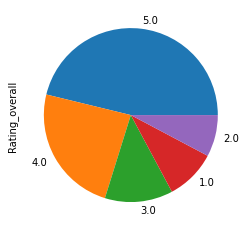

In [21]:
full_df.Rating_overall.value_counts().plot(kind='pie')

## Experiment 1 and 2:
TF-IDF with unscaled and scaled continuous features
Models: 
SVM
LSTM with scaled TF-IDF features


In [22]:
#define text processing libraries
review = full_df.full_review
rating = pro_df.Rating_overall
lemmatizer = WordNetLemmatizer()
sw = stopwords.words('english')

In [23]:
full_df.head()

,full_review,Rating_overall
0,"Not for faint-hearted Fast paced, technology, ...",5.0
1,Managers sold their soul to Verizon Good Team ...,1.0
2,Toxic environment and terrible management Oppo...,2.0
3,Fair The job is what was told. Very fair. Stil...,3.0
4,Good Company I have been working for the compa...,4.0


In [24]:
#define text processor- remove punctuation, convert to lowercase and eliminate stopwords
#def process_text(doc):
#   sw = set(stopwords.words('english'))
#    regex = re.compile("[^a-zA-Z ]")
#    re_clean = regex.sub('', doc)
##    words = word_tokenize(doc)
 #   lem = [lemmatizer.lemmatize(word) for word in doc]
 #   output = [word.lower() for word in lem if word.lower() not in sw]
 #   return output

In [25]:
def process_words(doc):
    # remove stopwords
    sw = stopwords.words('english')
    words = [word for word in doc if word.lower() not in sw]
    word = " ".join(words)

    # Remove punctuations and numbers
    word = re.sub('[^a-zA-Z]', ' ', doc)

    # lemmatize
    lem = [lemmatizer.lemmatize(word) for word in doc]

    # Single character removal
    word = re.sub(r"\s+[a-zA-Z]\s+", ' ', word)

    # Removing multiple spaces
    word = re.sub(r'\s+', ' ', word)

    # lowercase
    word = word.lower()

    return word

In [26]:
pro_df.head()

,pros,Rating_overall
0,"Fast paced, technology, innovation, supportive...",5.0
1,Good Team of people in Dublin and UK,1.0
2,"Opportunity to learn by doing, under a lot of ...",2.0
3,The job is what was told. Very fair.,3.0
4,I have been working for the company for about ...,4.0


In [27]:
processed = process_words(pro_df.pros[0])
print(processed)

fast paced technology innovation supportive upper management close knit community flexible lots of potential career growth this place has everything you need for an it company 


In [ ]:
#process text in full review column
full_df.full_review = full_df.full_review.apply(lambda doc: process_words(doc))
full_df.head()

In [ ]:
# Create the CountVectorizer instance defining the stopwords in English to be ignored
vectorizer = CountVectorizer(stop_words="english")

In [ ]:
# create tfidf vectorizer
tfidf = TfidfVectorizer(max_features=12000, ngram_range=(1,5), analyzer='char')

In [ ]:
X = tfidf.fit_transform(full_df['full_review'])

In [ ]:
y = full_df['Rating_overall']

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
#split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#check shape of datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# check accuracy
print(classification_report(y_test, y_pred))

In [ ]:
#test with '1 star' example
x = 'this job is really sucks bad i do not like it'
vec = tfidf.transform([x])
clf.predict(vec)

In [ ]:
#test with '5 star' example
x = 'this job is really great i love it'
vec = tfidf.transform([x])
clf.predict(vec)

## EDA on terms frequency weights

In [ ]:
# Get the tokenization and occurrence count
X_corpus = vectorizer.fit_transform(full_df.full_review)

In [ ]:

# Getting matrix info
print(f"Matrix shape: {X_corpus.shape}")
print(f"Total number of documents: {X_corpus.shape[0]}")
print(f"Total number of unique words (tokens): {X_corpus.shape[1]}")

In [ ]:
# Retrieve unique words list
words_corpus = vectorizer.get_feature_names()

In [ ]:
# Getting the TF-IDF weight of each word in corpus as DataFrame
words_corpus_df = pd.DataFrame(
    list(zip(words_corpus, np.ravel(X_corpus.mean(axis=0)))), columns=["Word", "TF-IDF"]
)

words_corpus_df = words_corpus_df.sort_values(by=["TF-IDF"], ascending=False)

In [ ]:
words_corpus_df = words_corpus_df.dropna()

In [ ]:
# Highest 50 TF-IDF scores
words_corpus_df.head(50)

In [ ]:
# Lowest 10 TF-IDF scores
words_corpus_df.tail(50)

In [ ]:
#wordcloud 
text = words_corpus_df.Word

# Get TF-IDF weights

print(words_corpus_df['TF-IDF'])
s_word_freq = pd.Series(words_corpus_df['TF-IDF'])
s_word_freq.index = words_corpus_df['Word']
di_word_freq = s_word_freq.to_dict()

#Create words and frequencies pairings
print("---")
print("di_word_freq:")
for k,v in di_word_freq.items():
  print(k,v)

# Display the generated image:

cloud = WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
plt.imshow(cloud)
plt.axis('off')
plt.show()


In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

In [ ]:
#use LSTM with scaled features
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = StandardScaler()
x_test_scaler = StandardScaler()
y_train_scaler = StandardScaler()
y_test_scaler = StandardScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()
model.add(LSTM(
    units=30, return_sequences=True,
    input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
 # Summarize the model
model.summary()

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

Experiment #3:

- Process "full" text into clean sentences
- tokenize sentence vectors using glove (Global Vectors)
- one hot encode by star rating
- train LSTM model to learn the relationships between 
    'review text' and 'star rating'
- determining good values for all the weights and the bias from review text
- The trained model will try to predict the star rating for each.
- We will then evaluate and plot the accuracy of the prediction

#### Text processing

In [ ]:
#word processor
#create a function responsible for cleaning the text into sentences that can be processed more accurately by a tokenizer
def process_words(doc):
    # Remove punctuations and numbers
    word = re.sub('[^a-zA-Z]', ' ', doc)

    # Single character removal
    word = re.sub(r"\s+[a-zA-Z]\s+", ' ', word)

    # Removing multiple spaces
    word = re.sub(r'\s+', ' ', word)

    return word

In [ ]:
#sentence processor
#create a function responsible for cleaning the text into sentences that can be processed more accurately by a tokenizer
def process_sentences(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

#### Split data between testing and training sets

In [ ]:
#Get 5 binary columns, one for each rating level
full_df_dummies = pd.get_dummies(full_df, columns = ['Rating_overall'])
full_df_dummies

In [ ]:
#Import Libraries
from sklearn.model_selection import train_test_split

In [ ]:
#create our input and output set. 
#The input is the text from the pros column in sentences. 
#Clean all the comments and will store them in the X variable. 
#The labels or outputs have already been stored in the pros_classified dataframe. 
# We will use that dataframe's values to store output in the y variable.


In [ ]:
X = []
sentences = list(full_df_dummies.full_review)
for sen in sentences:
    X.append(process_sentences(sen))

In [ ]:
y_columns = ['Rating_overall_1.0','Rating_overall_2.0','Rating_overall_3.0', 'Rating_overall_4.0','Rating_overall_5.0']
y_columns

In [ ]:
y_df = pd.DataFrame(columns=y_columns)
y_df['Rating_overall_1.0'] = full_df_dummies['Rating_overall_1.0'].astype(int)
y_df['Rating_overall_2.0'] = full_df_dummies['Rating_overall_2.0'].astype(int)
y_df['Rating_overall_3.0'] = full_df_dummies['Rating_overall_3.0'].astype(int)
y_df['Rating_overall_4.0'] = full_df_dummies['Rating_overall_4.0'].astype(int)
y_df['Rating_overall_5.0'] = full_df_dummies['Rating_overall_5.0'].astype(int)
y_df

In [ ]:
y = y_df.values
y

In [ ]:
#divide our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Tokenizing, Vectorizing 

In [ ]:
#convert text inputs into embedded vectors(tokenize)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 1200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

In [ ]:
#We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#creates the model.
#model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 5 neurons since we have 5 labels in the output.
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#model summary
print(model.summary())

In [ ]:
#train model
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
#We will train our model for 10 epochs.

In [ ]:
#evaluate our model on the test set:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
#plot the loss and accuracy values for training and test sets
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#where:

# 'Ratings_overall' is the predicted label (a desired output).
# is the bias (the y-intercept), sometimes referred to as .
# is the weight of feature 1. Weight is the same concept as the "slope"  in the traditional equation of a line.
# is a feature (a known input).
# To infer (predict) the temperature  for a new chirps-per-minute value , just substitute the  value into this model.

## Experiment 3: Random Forest

In [ ]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [ ]:
# Loading data
full_df.head()

In [ ]:
#Define X, y
X = full_df.full_review
y = full_df['Rating_overall']

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
 Confusion Matrix

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_


In [ ]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

In [ ]:
 # Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [ ]:
Experiment 4: Gradient Boosted Tree

In [ ]:
 import pandas as pd
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [ ]:
 # Load data
file_path = Path("../Resources/loans_data_encoded.csv")
loans_df = pd.read_csv(file_path)
loans_df.head()

In [ ]:
:  # Define features set
X = loans_df.copy()
X.drop("bad", axis=1, inplace=True)
X.head()

In [ ]:
# Define target vector
y = loans_df["bad"].values.reshape(-1, 1)
y[:5]

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train_scaled, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test.ravel())))
    print()

In [ ]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.75,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

In [ ]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

In [ ]:
 # Graph tree
dot_data = tree.export_graphviz(
    classifier.estimators_[9, 0],
    out_file=None, filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())